In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import netCDF4
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import catboost
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


#  Data Loading

In [2]:
summary_dir = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/summary'
# summary_dir = '/Users/yguo/DataSpellProjects/hw/uhi'


# merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables.feather')
# merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables_with_location_ID_event_ID.feather')
merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables_with_location_ID_event_ID_and_sur.feather')

local_hour_adjusted_df = pd.read_feather(merged_feather_path)
local_hour_adjusted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58245960 entries, 0 to 58245959
Data columns (total 74 columns):
 #   Column           Dtype         
---  ------           -----         
 0   index            int64         
 1   time             datetime64[ns]
 2   lat              float32       
 3   lon              float32       
 4   APPAR_TEMP       float32       
 5   APPAR_TEMP_R     float32       
 6   APPAR_TEMP_U     float32       
 7   EFLX_LH_TOT      float32       
 8   EFLX_LH_TOT_R    float32       
 9   EFLX_LH_TOT_U    float32       
 10  FGR              float32       
 11  FGR_R            float32       
 12  FGR_U            float32       
 13  FIRA             float32       
 14  FIRA_R           float32       
 15  FIRA_U           float32       
 16  FIRE             float32       
 17  FIRE_R           float32       
 18  FIRE_U           float32       
 19  FLDS             float32       
 20  FSA              float32       
 21  FSA_R            float32     

In [3]:
#count number of unique location_ID
local_hour_adjusted_df['location_ID'].nunique()

3704

In [ ]:
# # create a df that show the number of rows for each event_ID group by event_ID, show top 50

# event_counts = local_hour_adjusted_df.groupby('global_event_ID').size().reset_index(name='count')

# # Sort the DataFrame by count in descending order and show the top 50
# top_50_events = event_counts.sort_values('count', ascending=False).head(50)

# top_50_events




In [ ]:
# event_counts.query('count ==240') 

array([[<Axes: title={'center': 'count'}>]], dtype=object)

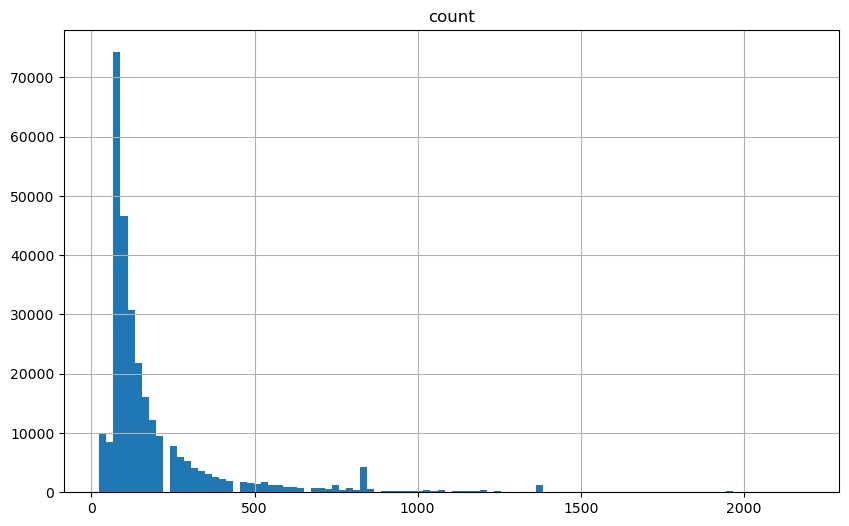

In [5]:
# #show histogram of event counts
# event_counts.hist(bins=100, figsize=(10, 6))

In [6]:
temp_one_event = local_hour_adjusted_df.query("global_event_ID == '44669_5'")


In [7]:
local_hour_adjusted_df.query("location_ID == 44669")

,index,time,lat,lon,APPAR_TEMP,APPAR_TEMP_R,APPAR_TEMP_U,EFLX_LH_TOT,EFLX_LH_TOT_R,EFLX_LH_TOT_U,...,UWBI_avg,UHI_diff,UWBI_diff,local_time,local_hour,location_ID,time_diff,new_event,event_ID,global_event_ID
14877244,14877244,1992-07-14 00:00:00,56.073299,36.25,14.733150,14.724317,17.245708,3.428068,3.363649,21.751566,...,0.690373,1.266479,0.484144,1992-07-14 02:00:00,2,44669,NaN,False,0,44669_0
14877946,14877946,1992-07-14 01:00:00,56.073299,36.25,15.272068,15.262150,18.093355,2.798144,2.756556,14.627576,...,0.764728,1.163958,0.774919,1992-07-14 03:00:00,3,44669,1.0,False,0,44669_0
14878648,14878648,1992-07-14 02:00:00,56.073299,36.25,15.953417,15.944427,18.510639,3.481630,3.450675,12.286314,...,0.725385,1.031543,0.615432,1992-07-14 04:00:00,4,44669,1.0,False,0,44669_0
14879350,14879350,1992-07-14 03:00:00,56.073299,36.25,17.766254,17.762020,18.970737,15.076033,15.075832,15.133006,...,0.320156,0.509931,0.100272,1992-07-14 05:00:00,5,44669,1.0,False,0,44669_0
14880052,14880052,1992-07-14 04:00:00,56.073299,36.25,21.174944,21.179657,19.834326,45.116749,45.199059,21.704348,...,-0.557410,-0.268482,-0.793711,1992-07-14 06:00:00,6,44669,1.0,False,0,44669_0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56774389,56774389,2013-06-30 19:00:00,56.073299,36.25,17.780174,17.770889,20.421127,19.949762,19.876091,40.904854,...,0.518590,1.483902,0.375632,2013-06-30 21:00:00,21,44669,1.0,False,7,44669_7
56775363,56775363,2013-06-30 20:00:00,56.073299,36.25,16.533447,16.524000,19.220505,14.632979,14.550077,38.213802,...,0.563225,1.476321,0.470303,2013-06-30 22:00:00,22,44669,1.0,False,7,44669_7
56776337,56776337,2013-06-30 21:00:00,56.073299,36.25,14.995717,14.987258,17.401787,14.345432,14.263536,37.639950,...,0.570919,1.299047,0.389404,2013-06-30 23:00:00,23,44669,1.0,False,7,44669_7
56777311,56777311,2013-06-30 22:00:00,56.073299,36.25,13.315827,13.308741,15.331646,14.287845,14.206510,37.422798,...,0.586912,0.994911,0.248135,2013-07-01 00:00:00,0,44669,1.0,False,7,44669_7


## load location_ID

In [8]:
location_ID_path = os.path.join(summary_dir, 'location_IDs.nc')
ds_location_ID = xr.open_dataset(location_ID_path, engine='netcdf4')

## load surface data

In [9]:
# Load the surface data file
fsurdat:str = os.path.join(summary_dir, 'surfdata_0.9x1.25_hist_16pfts_Irrig_CMIP6_simyr2000_c190214.nc')
ds_surface= xr.open_dataset(fsurdat, engine='netcdf4')


In [10]:
ds_surface

<xarray.Dataset> Size: 493MB
Dimensions:                  (lsmlat: 192, lsmlon: 288, nlevsoi: 10,
                              natpft: 15, cft: 2, time: 12, lsmpft: 17,
                              numurbl: 3, numrad: 2, nlevurb: 5, nglcecp1: 11,
                              nglcec: 10)
Coordinates:
  * natpft                   (natpft) int32 60B 0 1 2 3 4 5 ... 9 10 11 12 13 14
  * cft                      (cft) int32 8B 15 16
  * time                     (time) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lsmlat, lsmlon, nlevsoi, lsmpft, numurbl,
                                numrad, nlevurb, nglcecp1, nglcec
Data variables: (12/81)
    mxsoil_color             int32 4B ...
    SOIL_COLOR               (lsmlat, lsmlon) int32 221kB ...
    PCT_SAND                 (nlevsoi, lsmlat, lsmlon) float64 4MB ...
    PCT_CLAY                 (nlevsoi, lsmlat, lsmlon) float64 4MB ...
    ORGANIC                  (nlevsoi, lsmlat, lsmlon) float64 4MB ...
    FMAX                     (lsmlat, lsmlon) float64 442kB ...
    ...                       ...
    CONST_HARVEST_SH2        (lsmlat, lsmlon) float64 442kB ...
    CONST_HARVEST_SH3        (lsmlat, lsmlon) float64 442kB ...
    CONST_GRAZING            (lsmlat, lsmlon) float64 442kB ...
    CONST_FERTNITRO_CFT      (cft, lsmlat, lsmlon) float64 885kB ...
    UNREPRESENTED_PFT_LULCC  (natpft, lsmlat, lsmlon) float64 7MB ...
    UNREPRESENTED_CFT_LULCC  (cft, lsmlat, lsmlon) float64 885kB ...
Attributes: (12/50)
    Conventions:                          NCAR-CSM
    History_Log:                          created on: 02-14-19 10:18:19
    Logname:                              erik
    Host:                                 cheyenne3
    Source:                               Community Land Model: CLM5
    Version:                              release-clm5.0.18/gpfs/fs1/scratch/...
    ...                                   ...
    map_vic_file:                         map_0.9x1.25_GRDC_to_0.9x1.25_nomas...
    Soil_texture_raw_data_file_name:      mksrf_soitex.10level.c010119.nc
    Soil_color_raw_data_file_name:        mksrf_soilcolor_CMIP6_simyr2005.c17...
    Fmax_raw_data_file_name:              mksrf_fmax_3x3min_USGS_c120911.nc
    Organic_matter_raw_data_file_name:    mksrf_organic_10level_5x5min_ISRIC-...
    Vegetation_type_raw_data_filename:    mksrf_landuse_histclm50_LUH2_2000.c...

## load height data

In [11]:
# Load the surface data file
# the file can be found originally at: /home/jguo/projects/cesm/inputdata/atm/datm7/topo_forcing/topodata_0.9x1.25_USGS_070110_stream_c151201.nc
heightdat:str = os.path.join(summary_dir, 'topodata_0.9x1.25_USGS_070110_stream_c151201.nc')
ds_height= xr.open_dataset(heightdat, engine='netcdf4')

In [14]:
ds_height

NameError: name 'ds_height' is not defined

<bound method Dataset.info of <xarray.Dataset> Size: 887kB
Dimensions:      (lon: 288, lat: 192, time: 1)
Coordinates:
  * lon          (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lat          (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * time         (time) object 8B 0001-01-01 00:00:00
Data variables:
    location_ID  (lat, lon) int64 442kB ...
    TOPO         (time, lat, lon) float64 442kB ...>

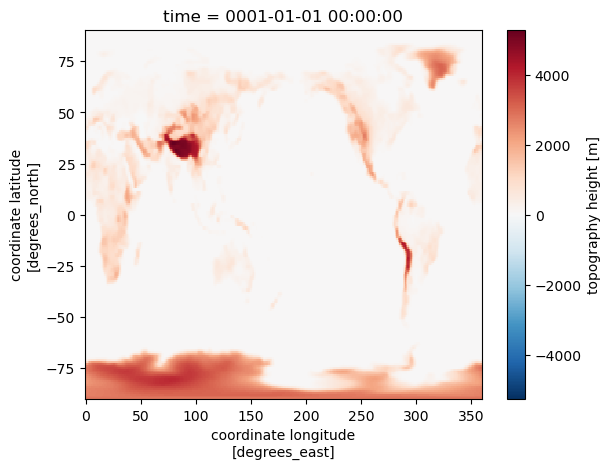

In [12]:
# mergo TOPO into location_ID_ds
ds_location_ID['TOPO'] = ds_height.TOPO
# location_ID_ds.location_ID.plot()
ds_location_ID.TOPO.plot()
ds_location_ID.info

In [13]:

# Assume ds_location_ID is the xarray dataset and local_hour_adjusted_df is the pandas DataFrame
# 1. Extract TOPO values and their corresponding lat, lon, and location_ID from the xarray dataset
topo_da = ds_location_ID['TOPO'].isel(time=0)  # Extract the TOPO values (time dimension is singleton)
location_id_da = ds_location_ID['location_ID']  # Extract the location_ID values

# Convert the TOPO values to a pandas DataFrame
topo_df = topo_da.to_dataframe(name='TOPO').reset_index()
location_id_df = location_id_da.to_dataframe(name='location_ID').reset_index()

# Merge the TOPO DataFrame with the location_ID DataFrame
merged_df = pd.merge(topo_df, location_id_df, on=['lat', 'lon'])

# 2. Merge the extracted TOPO values with the existing pandas DataFrame using location_ID
local_hour_adjusted_df = local_hour_adjusted_df.merge(merged_df[['location_ID', 'TOPO']], on='location_ID', how='left')

# Display or save the final DataFrame
local_hour_adjusted_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58245960 entries, 0 to 58245959
Data columns (total 74 columns):
 #   Column           Dtype         
---  ------           -----         
 0   index            int64         
 1   time             datetime64[ns]
 2   lat              float32       
 3   lon              float32       
 4   APPAR_TEMP       float32       
 5   APPAR_TEMP_R     float32       
 6   APPAR_TEMP_U     float32       
 7   EFLX_LH_TOT      float32       
 8   EFLX_LH_TOT_R    float32       
 9   EFLX_LH_TOT_U    float32       
 10  FGR              float32       
 11  FGR_R            float32       
 12  FGR_U            float32       
 13  FIRA             float32       
 14  FIRA_R           float32       
 15  FIRA_U           float32       
 16  FIRE             float32       
 17  FIRE_R           float32       
 18  FIRE_U           float32       
 19  FLDS             float32       
 20  FSA              float32       
 21  FSA_R            float32     

In [15]:
local_hour_adjusted_df[['TOPO', 'location_ID']].head()

,TOPO,location_ID
0,179.726493,13770
1,179.726493,13770
2,179.726493,13770
3,179.726493,13770
4,179.726493,13770


In [16]:
# merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables_with_location_ID_event_ID_and_sur.feather')
# local_hour_adjusted_df.to_feather(merged_feather_path)

##  Add in surface roughness

In [4]:
# The aerodynamic resistance was obtained from the following diagnostic relationship,

# Where Ta,2 and Ta,b are 2m and blending height air temperatures, respectively, and H is sensible
# heat flux.
# T a,b is TBOT. After calculation, remove smaller than 0 or larger than 800. Negative is physically
# unreasonable and too large is never observed in reality.

Cp=1004 # J/(kg·K)
density=1.184 # kg/m3
Thre_ra0=0;Thre_ra1=800

# CURa=density*Cp*(CUTa-CUTBOT)/CUFSH
# CURa=np.ma.masked_where((CURa<Thre_ra0) | (CURa>Thre_ra1),CURa)
local_hour_adjusted_df['RA'] = density * Cp * (local_hour_adjusted_df['TSA'] - local_hour_adjusted_df['TBOT']) / local_hour_adjusted_df['FSH']

In [7]:
local_hour_adjusted_df['RA'].sort_values(ascending=False)

14551803    1.300569e+09
42034430    6.535038e+08
22625161    4.771393e+08
45940938    1.666947e+08
2048571     1.649120e+08
                ...     
39264880   -8.306905e+07
30069641   -8.828692e+07
33733084   -1.090525e+08
32660761   -1.399536e+08
47524061   -1.532457e+08
Name: RA, Length: 58245960, dtype: float32

<Axes: >

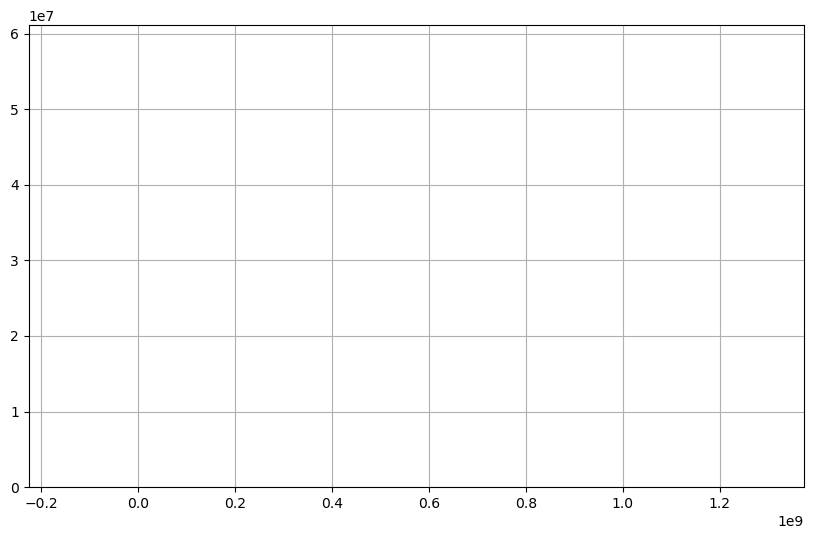

In [8]:
#PLOT Histogram of RA
local_hour_adjusted_df['RA'].hist(bins=10000, figsize=(10, 6))

<Axes: >

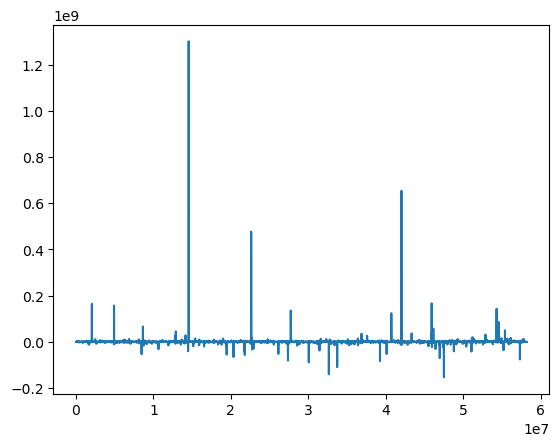

In [9]:
# plot RA
local_hour_adjusted_df['RA'].plot()

In [13]:
#count pct of RA < 0
print((local_hour_adjusted_df['RA'] < 0).sum() / len(local_hour_adjusted_df))
print((local_hour_adjusted_df['RA'] > 800).sum() / len(local_hour_adjusted_df))

0.149235157253825
0.011367741213296166


## Feature list loading

In [17]:
df_daily_vars = pd.read_excel('../Data/hourlyDataSchema.xlsx')
daily_vars =df_daily_vars.loc[df_daily_vars['X_vars2'] == 'Y', 'Variable']
daily_var_lst = daily_vars.tolist()
daily_var_lst

['EFLX_LH_TOT',
 'FGR',
 'FIRA',
 'FLDS',
 'FSA',
 'FSDS',
 'FSH',
 'PBOT',
 'Q2M',
 'TSA',
 'U10',
 'URBAN_HEAT']

In [18]:
df_daily_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Variable            57 non-null     object 
 1   Long Name           57 non-null     object 
 2   Long Name Original  57 non-null     object 
 3   Units               53 non-null     object 
 4   Cell Methods        52 non-null     object 
 5   Fill Value          57 non-null     object 
 6   Missing Value       57 non-null     object 
 7   X_vars_delta        6 non-null      object 
 8   X_vars2             14 non-null     object 
 9   X_selected          11 non-null     object 
 10  Notes               0 non-null      float64
dtypes: float64(1), object(10)
memory usage: 5.0+ KB


##  Delta feature list loading

In [19]:
# Load delta feature list
delta_vars = df_daily_vars.loc[df_daily_vars['X_vars_delta'] == 'Y', 'Variable']
delta_var_lst = delta_vars.tolist()

# Calculate delta variables and add to dataframe
for var in delta_var_lst:
    var_U = f"{var}_U"
    var_R = f"{var}_R"
    delta_var = f"delta_{var}"
    if var_U in local_hour_adjusted_df.columns and var_R in local_hour_adjusted_df.columns:
        local_hour_adjusted_df[delta_var] = local_hour_adjusted_df[var_U] - local_hour_adjusted_df[var_R]
        daily_var_lst.append(delta_var)  # Add delta variable to daily_var_lst
    else:
        print(f"Warning: {var_U} or {var_R} not found in dataframe columns.")


In [20]:
local_hour_adjusted_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58245960 entries, 8945088 to 56705927
Data columns (total 79 columns):
 #   Column             Dtype         
---  ------             -----         
 0   index              int64         
 1   time               datetime64[ns]
 2   lat                float32       
 3   lon                float32       
 4   APPAR_TEMP         float32       
 5   APPAR_TEMP_R       float32       
 6   APPAR_TEMP_U       float32       
 7   EFLX_LH_TOT        float32       
 8   EFLX_LH_TOT_R      float32       
 9   EFLX_LH_TOT_U      float32       
 10  FGR                float32       
 11  FGR_R              float32       
 12  FGR_U              float32       
 13  FIRA               float32       
 14  FIRA_R             float32       
 15  FIRA_U             float32       
 16  FIRE               float32       
 17  FIRE_R             float32       
 18  FIRE_U             float32       
 19  FLDS               float32       
 20  FSA                fl

In [12]:
def get_long_names(variables, df):
    """
    This function takes a list of variable names and a DataFrame, 
    and returns a list of corresponding long names in the format 'input_name (long name)'.

    Parameters:
    variables (list): List of variable names to look up.
    df (DataFrame): DataFrame containing the variable and long name columns.

    Returns:
    list: List of formatted strings 'input_name (long name)' corresponding to the given variable names.
    """
    formatted_names = []
    for var in variables:
        long_name = df.loc[df['Variable'] == var, 'Long Name'].values
        if long_name.size > 0:
            formatted_names.append(f"{var} ({long_name[0]})")
        else:
            formatted_names.append(f"{var} (No long name found)")  # or some other default value
    return formatted_names

In [13]:
def add_long_name(input_df, join_column='Feature', df_daily_vars=df_daily_vars):
    # Perform a left join on the input dataframe using the specified join column
    # This will add all columns from df_daily_vars to input_df where the join_column matches the 'Variable' in df_daily_vars
    merged_df = pd.merge(input_df, df_daily_vars[['Variable', 'Long Name']], left_on=join_column, right_on='Variable', how='left')

    # Since the 'Variable' column from df_daily_vars will be redundant, we can drop it
    merged_df.drop(columns=['Variable'], inplace=True)

    # Return the modified DataFrame
    return merged_df


##  Day Night mask

In [14]:
# Step 1: Define masks for daytime and nighttime
daytime_mask = local_hour_adjusted_df['local_hour'].between(8, 16)
nighttime_mask = (local_hour_adjusted_df['local_hour'].between(20, 24) |
                  local_hour_adjusted_df['local_hour'].between(0, 4))


In [15]:
daytime_uhi_diff = local_hour_adjusted_df[daytime_mask]
X_day = daytime_uhi_diff[daily_var_lst]
y_day = daytime_uhi_diff['UHI_diff']
X_day.info()
y_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21842235 entries, 8947194 to 56695507
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   EFLX_LH_TOT  float32
 1   FGR          float32
 2   FIRA         float32
 3   FLDS         float32
 4   FSA          float32
 5   FSDS         float32
 6   FSH          float32
 7   PBOT         float32
 8   Q2M          float32
 9   TSA          float32
 10  U10          float32
dtypes: float32(11)
memory usage: 1.1 GB
<class 'pandas.core.series.Series'>
Index: 21842235 entries, 8947194 to 56695507
Series name: UHI_diff
Non-Null Count     Dtype  
--------------     -----  
21842235 non-null  float32
dtypes: float32(1)
memory usage: 250.0 MB


In [16]:
nighttime_uhi_diff = local_hour_adjusted_df[nighttime_mask]
X_night = nighttime_uhi_diff[daily_var_lst]
y_night = nighttime_uhi_diff['UHI_diff']

X_night.info()
y_night.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21842235 entries, 8945250 to 56705927
Data columns (total 11 columns):
 #   Column       Dtype  
---  ------       -----  
 0   EFLX_LH_TOT  float32
 1   FGR          float32
 2   FIRA         float32
 3   FLDS         float32
 4   FSA          float32
 5   FSDS         float32
 6   FSH          float32
 7   PBOT         float32
 8   Q2M          float32
 9   TSA          float32
 10  U10          float32
dtypes: float32(11)
memory usage: 1.1 GB
<class 'pandas.core.series.Series'>
Index: 21842235 entries, 8945250 to 56705927
Series name: UHI_diff
Non-Null Count     Dtype  
--------------     -----  
21842235 non-null  float32
dtypes: float32(1)
memory usage: 250.0 MB


#  Getting sense of relationships of feature and label

##  Linear beta, Slope CI and P value for each feature

In [17]:
day_full_pool = Pool(X_day, y_day)
night_full_pool = Pool(X_night, y_night)

In [18]:
from scipy.stats import linregress
import pandas as pd
import numpy as np

def feature_linear_slope(df, feature_name, label, confidence_level=0.95):
    # Compute linear regression and get the slope, intercept, r-value, p-value, and standard error
    slope, _, _, p_value, stderr = linregress(df[feature_name], df[label])
    # Calculate the critical value for the given confidence level
    t_value = np.abs(np.percentile(np.random.standard_t(df[feature_name].shape[0] - 2, 100000), [(1-confidence_level)/2, 1-(1-confidence_level)/2]))[1]
    # Calculate the margin of error
    margin_of_error = t_value * stderr
    return slope, margin_of_error, p_value

def combine_slopes(daytime_df, nighttime_df, features, labels=['UHI', 'UHI_diff'], confidence_level=0.95):
    # Initialize a dictionary to hold the data
    data = {}

    # Loop over each feature
    for feature in features:
        # List to store slopes and confidence intervals for current feature across all conditions
        slopes_with_intervals = []
        
        # Collect slopes and confidence intervals for each dataset and label
        for df, time in [(daytime_df, 'Day'), (nighttime_df, 'Night')]:
            for label in labels:
                slope, margin_of_error, p_value = feature_linear_slope(df, feature, label, confidence_level)
                # Create the slope with confidence interval and p-value string
                slope_with_interval = f"{slope:.6f} (± {margin_of_error:.6f}, P: {p_value:.6f})"
                slopes_with_intervals.append(slope_with_interval)
        
        # Store the slopes with confidence intervals in the dictionary, with the feature as the key
        data[feature] = slopes_with_intervals

    # Convert the dictionary to DataFrame
    columns = [f'{time}_{label}_slope' for time in ['Day', 'Night'] for label in labels]
    results_df = pd.DataFrame(data, index=columns).transpose()

    return results_df

feature_names = day_full_pool.get_feature_names()
results_df = combine_slopes(daytime_uhi_diff, nighttime_uhi_diff, feature_names)
results_df.sort_values('Day_UHI_slope', ascending=False)



,Day_UHI_slope,Day_UHI_diff_slope,Night_UHI_slope,Night_UHI_diff_slope
U10,"0.125518 (± 0.000296, P: 0.000000)","-0.004366 (± 0.000165, P: 0.000000)","-0.107262 (± 0.000253, P: 0.000000)","-0.052122 (± 0.000136, P: 0.000000)"
TSA,"0.063322 (± 0.000100, P: 0.000000)","-0.002826 (± 0.000057, P: 0.000000)","0.002065 (± 0.000079, P: 0.000000)","-0.002828 (± 0.000043, P: 0.000000)"
FIRA,"0.005498 (± 0.000007, P: 0.000000)","-0.000490 (± 0.000004, P: 0.000000)","0.004344 (± 0.000013, P: 0.000000)","0.001776 (± 0.000007, P: 0.000000)"
FSH,"0.003007 (± 0.000004, P: 0.000000)","0.000070 (± 0.000002, P: 0.000000)","-0.007477 (± 0.000021, P: 0.000000)","-0.004385 (± 0.000011, P: 0.000000)"
FSDS,"0.001311 (± 0.000002, P: 0.000000)","0.000070 (± 0.000001, P: 0.000000)","0.014698 (± 0.000157, P: 0.000000)","0.005237 (± 0.000085, P: 0.000000)"
FSA,"0.001189 (± 0.000002, P: 0.000000)","0.000118 (± 0.000001, P: 0.000000)","0.018560 (± 0.000196, P: 0.000000)","0.006697 (± 0.000106, P: 0.000000)"
FGR,"0.001145 (± 0.000006, P: 0.000000)","-0.000253 (± 0.000003, P: 0.000000)","-0.000711 (± 0.000012, P: 0.000000)","0.000036 (± 0.000006, P: 0.000000)"
Q2M,"-41.801117 (± 0.058107, P: 0.000000)","-2.283894 (± 0.033137, P: 0.000000)","-20.178095 (± 0.052599, P: 0.000000)","-5.672579 (± 0.028895, P: 0.000000)"
FLDS,"-0.001805 (± 0.000013, P: 0.000000)","0.000919 (± 0.000007, P: 0.000000)","-0.002580 (± 0.000009, P: 0.000000)","-0.001403 (± 0.000005, P: 0.000000)"
EFLX_LH_TOT,"-0.001010 (± 0.000004, P: 0.000000)","0.000537 (± 0.000002, P: 0.000000)","-0.000811 (± 0.000019, P: 0.000000)","-0.000119 (± 0.000010, P: 0.000000)"


## Some observations, thoughts and questions.

In [19]:
# 1. note that for UHI ~ U10 slope, the daytime slope is positive and the nighttime slope is negative
# however for UHI_diff ~ U10 slope, the daytime and nighttime slope are both negative, which is inconsistent with (Dan Li et al. 2016 Changes in Wind Speed under Heat Waves Enhance Urban Heat Islands in the Beijing Metropolitan Area)

# 2. Q2M is negative???

In [20]:
daytime_uhi_diff[feature_names].describe()

,EFLX_LH_TOT,FGR,FIRA,FLDS,FSA,FSDS,FSH,PBOT,Q2M,TSA,U10
count,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07,2.184224e+07
mean,1.449397e+02,1.063166e+02,1.267803e+02,4.029256e+02,5.025129e+02,6.045804e+02,1.244846e+02,9.589119e+04,1.445100e-02,3.066066e+02,3.014395e+00
std,1.044662e+02,6.626863e+01,5.454506e+01,3.377031e+01,1.784967e+02,2.178960e+02,9.667429e+01,6.720920e+03,6.936407e-03,2.806667e+01,1.384413e+00
min,-3.654014e+02,-3.765916e+02,-9.234869e+01,2.350358e+02,7.515556e-01,8.976600e-01,-2.186229e+02,7.386439e+04,4.733410e-04,2.682860e+02,4.881164e-01
25%,5.302910e+01,5.358280e+01,8.354679e+01,3.827422e+02,3.674444e+02,4.413369e+02,4.265466e+01,9.428065e+04,8.293897e-03,3.039807e+02,1.944991e+00
50%,1.205087e+02,1.040666e+02,1.176701e+02,4.092747e+02,5.195067e+02,6.250395e+02,1.094941e+02,9.742280e+04,1.457194e-02,3.062955e+02,2.740048e+00
75%,2.260686e+02,1.556890e+02,1.654784e+02,4.262935e+02,6.446540e+02,7.811445e+02,1.911520e+02,9.941032e+04,2.002058e-02,3.088826e+02,3.803425e+00
max,7.874184e+02,8.632037e+02,4.043884e+02,5.448807e+02,1.206133e+03,1.438224e+03,7.672695e+02,1.027793e+05,8.981472e-02,3.321967e+02,1.634675e+01


#   Using CatBoost model to study feature behaviours 

##  Functions to create model and graph

In [21]:
# day_full_pool = Pool(X_day, y_day)
# night_full_pool = Pool(X_night, y_night)

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
import shap

def train_and_evaluate(time_uhi_diff, df_daily_vars):
    daily_vars =df_daily_vars.loc[df_daily_vars['X_vars2'] == 'Y', 'Variable']
    daily_var_lst = daily_vars.tolist()
    # Select features and target
    X = time_uhi_diff[daily_var_lst]
    y = time_uhi_diff['UHI_diff']

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_pool = Pool(X_train, y_train)
    validation_pool = Pool(X_val, y_val)

    # Train the final model with all columns on selected features after feature selection
    model = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.03,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        task_type='GPU',
        early_stopping_rounds=100,
        verbose=False
    )
    model.fit(X_train, y_train, eval_set=(X_val, y_val),
                       use_best_model=True, early_stopping_rounds=50, 
                       plot=True, 
                       verbose=False)
    return model

def importance_plot(model, validation_pool, df_daily_vars):
    # Get long_feature_names
    feature_names = validation_pool.get_feature_names()
    feature_name_mapping = pd.Series(df_daily_vars['Long Name'].values, index=df_daily_vars['Variable']).to_dict()
    long_feature_names = [feature_name_mapping.get(name, "Unknown Feature") for name in feature_names]
    # Calculate SHAP values    
    explainer = shap.TreeExplainer(model, feature_names=long_feature_names)
    shap_values = explainer.shap_values(validation_pool)
    mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
    # Normalize the SHAP values so that they sum to one
    total = mean_abs_shap_values.sum()
    normalized_shap_values = mean_abs_shap_values / total
    # Plot the SHAP values for the first instance in the validation dataset
    shap.waterfall_plot(shap.Explanation(normalized_shap_values, base_values=explainer.expected_value,
                                         data=validation_pool.get_features()[0],
                                         feature_names=validation_pool.get_feature_names()))
    
    shap.plots.waterfall(shap_values)


##  Train both night and day models

In [23]:
night_model = train_and_evaluate(nighttime_uhi_diff, df_daily_vars=df_daily_vars)
day_model = train_and_evaluate(daytime_uhi_diff, df_daily_vars=df_daily_vars)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
#saving models
night_model.save_model('/home/jguo/research/hw_global/results/model_night_model_lr003_it3000_depth6.cbm')
day_model.save_model('/home/jguo/research/hw_global/results/model_day_model_lr003_it3000_depth6.cbm')

## Feature importance

In [25]:
def get_ordered_feature_importance(model: CatBoostRegressor, pool, type='FeatureImportance'):
    if type == 'FeatureImportance':
        feature_importances = model.get_feature_importance()
    else:
        feature_importances = model.get_feature_importance(pool, type=type)
    feature_importance_df = pd.DataFrame({'Feature': pool.get_feature_names(), 'Importance': feature_importances})
    feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    
    feature_importance_df = add_long_name(feature_importance_df, join_column='Feature')
    return feature_importance_df

In [26]:
# Get feature importance
get_ordered_feature_importance(day_model, day_full_pool)


,Feature,Importance,Long Name
0,U10,16.955792,10-m wind
1,Q2M,16.288015,2m specific humidity
2,FSH,15.669898,sensible heat
3,EFLX_LH_TOT,13.516576,total latent heat flux [+ to atm]
4,PBOT,7.960314,atmospheric pressure at surface
5,FIRA,7.735166,net infrared (longwave) radiation
6,TSA,6.983964,2m air temperature
7,FGR,6.776036,heat flux into soil/snow
8,FLDS,3.661798,atmospheric longwave radiation
9,FSDS,3.596110,atmospheric incident solar radiation


In [27]:
# Get feature importance
get_ordered_feature_importance(day_model, day_full_pool, type='LossFunctionChange')


,Feature,Importance,Long Name
0,U10,0.021065,10-m wind
1,Q2M,0.011413,2m specific humidity
2,FGR,0.008309,heat flux into soil/snow
3,FSH,0.008036,sensible heat
4,EFLX_LH_TOT,0.006517,total latent heat flux [+ to atm]
5,TSA,0.004192,2m air temperature
6,FIRA,0.004065,net infrared (longwave) radiation
7,PBOT,0.003969,atmospheric pressure at surface
8,FSDS,0.003403,atmospheric incident solar radiation
9,FLDS,0.001394,atmospheric longwave radiation


In [28]:
get_ordered_feature_importance(night_model, night_full_pool)  

,Feature,Importance,Long Name
0,FSH,24.518542,sensible heat
1,U10,21.379339,10-m wind
2,Q2M,10.462233,2m specific humidity
3,EFLX_LH_TOT,9.624970,total latent heat flux [+ to atm]
4,PBOT,9.530647,atmospheric pressure at surface
5,FIRA,8.653458,net infrared (longwave) radiation
6,TSA,7.939467,2m air temperature
7,FGR,4.904760,heat flux into soil/snow
8,FLDS,2.835109,atmospheric longwave radiation
9,FSA,0.115936,absorbed solar radiation


In [29]:
get_ordered_feature_importance(night_model, night_full_pool, type='LossFunctionChange')

,Feature,Importance,Long Name
0,FSH,0.034636,sensible heat
1,U10,0.026528,10-m wind
2,TSA,0.005727,2m air temperature
3,Q2M,0.004683,2m specific humidity
4,FGR,0.003531,heat flux into soil/snow
5,PBOT,0.003304,atmospheric pressure at surface
6,FIRA,0.003246,net infrared (longwave) radiation
7,EFLX_LH_TOT,0.003144,total latent heat flux [+ to atm]
8,FLDS,0.002069,atmospheric longwave radiation
9,FSA,0.000047,absorbed solar radiation


In [30]:
import catboost
from catboost import *
import shap
shap.initjs() 

## Summary beeswarm plot

### Daytime model

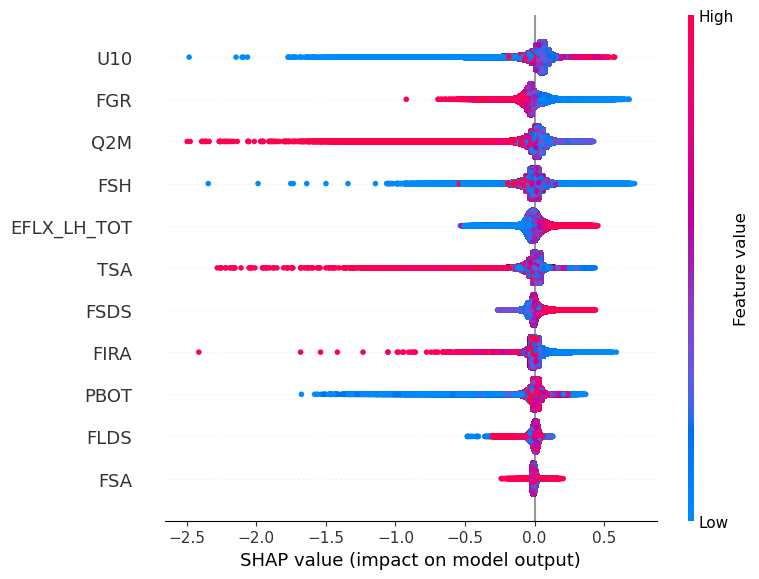

In [32]:
day_shap_values = day_model.get_feature_importance(day_full_pool, type='ShapValues')

expected_value = day_shap_values[0,-1]
day_shap_values = day_shap_values[:,:-1]

shap.summary_plot(day_shap_values, X_day)

In [ ]:
day_feature_importances = day_model.get_feature_importance()
long_names = get_long_names(day_full_pool.get_feature_names(), df_daily_vars)
shap.waterfall_plot(shap.Explanation(day_feature_importances, base_values=expected_value, 
                                    #  data=night_shap_values, 
                                     feature_names=long_names))

###  Nighttime model

In [ ]:
night_shap_values = night_model.get_feature_importance(night_full_pool, type='ShapValues')

night_expected_value = night_shap_values[0,-1]
night_shap_values = night_shap_values[:,:-1]

# shap.summary_plot(night_shap_values, X_night)

In [ ]:
shap.summary_plot(night_shap_values, X_night)

In [ ]:
night_feature_importances = night_model.get_feature_importance()
shap.waterfall_plot(shap.Explanation(night_feature_importances, base_values=night_expected_value, 
                                    #  data=night_shap_values, 
                                     feature_names=night_full_pool.get_feature_names()))

In [ ]:
type(day_full_pool.get_feature_names())

In [ ]:
print(sum(shap_values[0,:]))

In [ ]:
q2m_mean = local_hour_adjusted_df['Q2M'].mean()

In [ ]:
local_hour_adjusted_df.groupby(local_hour_adjusted_df['Q2M'] > 0)['UHI_diff'].mean()

##  Dependence plots for all feature pairs

In [ ]:
import shap
import matplotlib.pyplot as plt

# Calculate SHAP values for day and night models
day_shap_values = day_model.get_feature_importance(day_full_pool, type='ShapValues')[:,:-1]
# night_shap_values = night_model.get_feature_importance(night_full_pool, type='ShapValues')[:,:-1]

# Get the feature names for SHAP values
day_feature_names = day_full_pool.get_feature_names()
# night_feature_names = night_full_pool.get_feature_names()


In [ ]:

# Define a function to plot SHAP dependence plots for U10 against other features excluding itself
def plot_dependence_grid(shap_values, X, feature_names, target_feature='U10', plots_per_row=3):
    """
    Plots the dependence grid for a given target feature and a list of feature names.

    Parameters:
    - shap_values (array-like): The SHAP values for the target feature.
    - X (array-like): The input features.
    - feature_names (list): The list of feature names.
    - target_feature (str): The target feature to plot against.
    - plots_per_row (int): The number of plots to display per row.

    Returns:
    None
    """
    feature_names = [f for f in feature_names if f != target_feature]
    num_features = len(feature_names)
    num_rows = (num_features + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(30, 10 * num_rows))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, feature_name in enumerate(feature_names):
        shap.dependence_plot(ind=target_feature, shap_values=shap_values, features=X, interaction_index=feature_name, ax=axes[i],  show=False)
        axes[i].set_title(f"Day time {target_feature} vs {feature_name}")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Plot dependence plots for daytime
print("Daytime Model Dependence Plots for U10")
plot_dependence_grid(day_shap_values, X_day, day_feature_names, 'U10', 2)

print("Daytime Model Dependence Plots for Q2M")
plot_dependence_grid(day_shap_values, X_day, day_feature_names, 'Q2M', 2)

# # Plot dependence plots for nighttime
# print("Nighttime Model Dependence Plots for U10")
# plot_dependence_grid(night_shap_values, X_night, night_feature_names)